In [1]:
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]


In [2]:
df = pd.read_csv('clean_data_scaled.csv')
df.head()

,UDI,Type,Air.temperature,Process.temperature,Rotational.speed,Torque,Tool.wear,Machine.failure
0,1,2,-0.952342,-0.947313,0.068182,0.282186,-1.695899,0
1,2,1,-0.902348,-0.879915,-0.729435,0.633276,-1.648769,0
2,3,1,-0.952342,-1.014710,-0.227438,0.944242,-1.617349,0
3,4,1,-0.902348,-0.947313,-0.589992,-0.048843,-1.585930,0
4,5,1,-0.902348,-0.879915,-0.729435,0.001313,-1.554510,0


### Specify features and labels

In [3]:
feature_names = df.columns[1:7]

### Let's look at the counts of each machine type for failure and no failure

Type                1     2    3
Machine.failure                 
0                5765  2914  982
1                 235    83   21


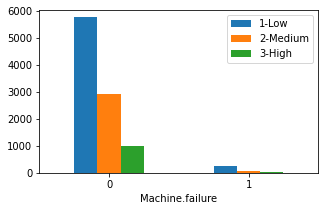

In [4]:
failure_by_type = (df[['Type', 'Machine.failure']].copy())#.groupby(['Machine.failure','Type'])
failure_by_typep = failure_by_type.pivot_table(index='Machine.failure', columns='Type', values='Type', aggfunc='size')
print(failure_by_typep)
ax0 = failure_by_typep.plot(kind='bar', figsize=(5, 3), rot=0)
ax0.legend(['1-Low', '2-Medium', '3-High'])

### Let's look at the proportion of machine failures by type

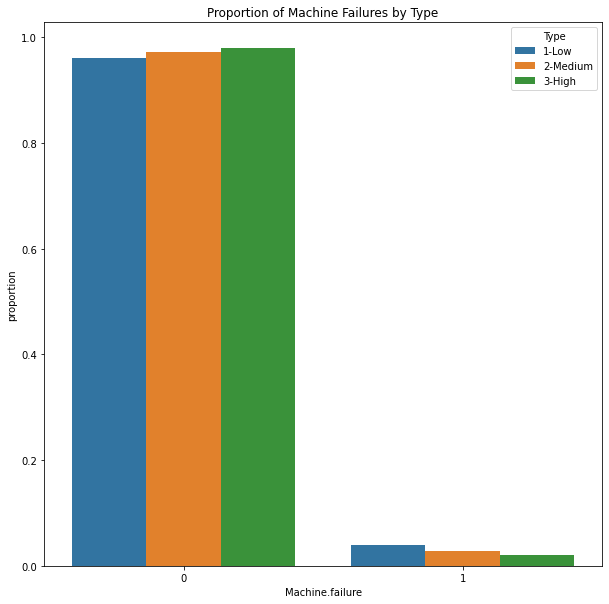

In [5]:
x, y, hue = 'Machine.failure', "proportion",'Type'
hue_order = ['1-Low', '2-Medium', '3-High']

bp = (failure_by_type[x]
    .groupby(df[hue])
    .value_counts(normalize=True)
    .rename(y)
    .reset_index()
    .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

legend_labels, _= bp.get_legend_handles_labels()
bp.legend(legend_labels, ['1-Low', '2-Medium', '3-High'], title='Type')
bp.set(title='Proportion of Machine Failures by Type')
plt.show()

Machine parts of `Type 1 - Low quality` had the highest proportion of machine failures, while `ype 3 - High quality` had the lowest proportion of machine failures.

### Train a kNN classifier

In [7]:
y = df['Machine.failure']
X = df.iloc[:,1:7]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
knn = KNeighborsClassifier(n_neighbors=5)

### Use GridSearchCV to Find a good number of neighbors

{'n_neighbors': 3}


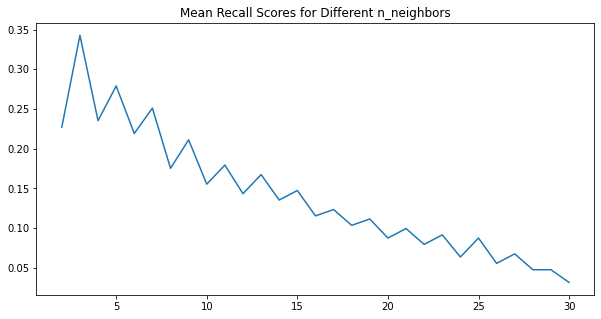

In [36]:
k_range = list(range(2, 31))
# create a parameter grid/dict: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
grid.fit(X_train, y_train)
# view the complete results (list of named tuples)
grid_mean_scores = grid.cv_results_["mean_test_score"]
plt.figure(figsize=(10, 5))
plt.title('Mean Recall Scores for Different n_neighbors')
plt.plot(k_range, grid_mean_scores)
print(grid.best_params_)
k = grid.best_params_['n_neighbors']


In [37]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=3)

### Evaluate kNN model

In [25]:
y_pred_knn = knn.predict(X_test)

[[2395   17]
 [  55   33]]


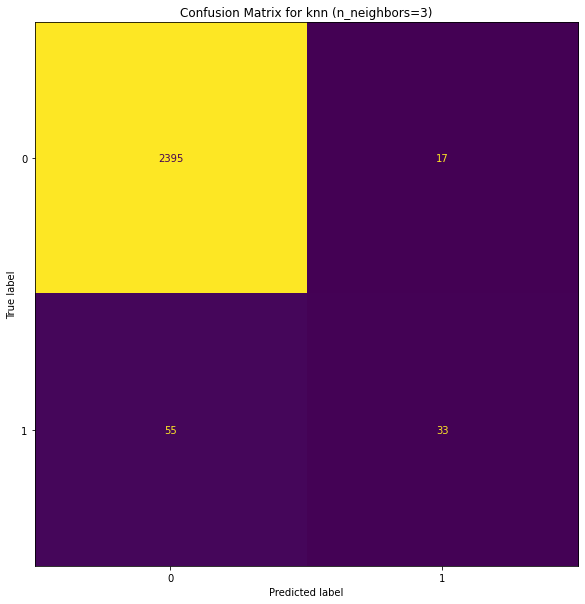

In [38]:
disp_knn = plot_confusion_matrix(knn, X_test, y_test, colorbar=False)

plt.title("Confusion Matrix for knn (n_neighbors=3)")

print(disp_knn.confusion_matrix)

## Performance Metrics

In [39]:
print(classification_report(y_test, y_pred_knn))
scores = cross_val_score(knn, X, y, cv =5, scoring="recall")
# print('kNN Model accuracy with Cross Validation: ',np.mean(scores))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2412
           1       0.46      0.43      0.45        88

    accuracy                           0.96      2500
   macro avg       0.72      0.71      0.71      2500
weighted avg       0.96      0.96      0.96      2500

